## About

This notebook is about writing _efficient_ and _scalable_ array processing 
code using Python. 

Typical use cases include:

* Generation of of multi-variate, multi-dimensional gridded data cubes from 
  source data.
* Transformation of and value adding to multi-variate and multi-dimensional 
  gridded data cubes.

## Goal

There are many ways to write Python array processing code in Python.
Not only there are many programming styles that may be used. Also programmers 
can also choose from a large range of array processing libararies, with 
`numpy` and `scipy` probably being best known.

This notebook attempts to provide to you a guide for writing _efficient_ and
_scalable_ array processing code, without forcing you to deal with the details 
of parallelisation such as writing special code for multi-threaded or 
multi-process batch processing environments.

The only assumption is that the type of data arrays used for the processing 
code is internally subdivided into smaller data chunks. Smaller means, 
a subset of data chunks is ecpected to to fit into the memory of a common 
computer, but not necessarily all chunks of large arrays.

For processing of subsets of the data, it is expected that only data 
chunks intersecting the user's area of interest are loaded and processed.
For bulk processing of large data cubes, the internal chunking is also 
the key for concurrent processing of chunks on a cluster of computers.

The ultimate goal is therefore writing code that supports, exploits, and 
retains the chunked nature of data arrays.

## Introduction

It is assumed our main data model is provided by 
[`xarray.Dataset`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html)
that is composed of 
[`xarray.DataArray`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html)
objects that is used to both represent data variables and coordinate variables.
The actual data of a variable may be provided by any object compatible
with the 
[`numpy.ndarray`](https://numpy.org/doc/stable/reference/arrays.ndarray.html)
interface. When loading an `xarray.Dataset` from a source supporting chunks,
array data will represented by 
[`dask.Array`](https://docs.dask.org/en/stable/array.html)
objects. For example, this is the case for chunked NetCDF files using 
`xarray.open_dataset()`, for datasets stored in 
[Zarr](https://zarr.readthedocs.io/) format using `xarray.open_zarr()`, 
or datasets loaded from various [xcube](https://xcube.readthedocs.io/) data stores. 

Shown here is using the xcube data store for the Sentinel Hub API, where the `tile_size` parameter defines the chunking of data arrays:

In [1]:
from xcube.core.store import new_data_store 
store = new_data_store('sentinelhub')

cube = store.open_data('S2L2A',                      
                       bbox=[9.7, 53.4, 10.2, 53.7],
                       spatial_res=0.00018,
                       time_range=('2020-08-10','2020-08-13'),
                       time_period='1D',
                       tile_size=[1024, 1024])
cube

<xarray.Dataset>
Dimensions:           (bnds: 2, lat: 2048, lon: 3072, time: 4)
Coordinates:
  * lat               (lat) float64 53.77 53.77 53.77 53.77 ... 53.4 53.4 53.4
  * lon               (lon) float64 9.7 9.7 9.7 9.701 ... 10.25 10.25 10.25
  * time              (time) datetime64[ns] 2020-08-10T12:00:00 ... 2020-08-1...
    time_bnds         (time, bnds) datetime64[ns] dask.array<chunksize=(4, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables: (12/22)
    AOT               (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B01               (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B02               (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03               (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04               (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B05               (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ...                ...
    SCL               (time, lat, lon) uint8 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SNW               (time, lat, lon) uint8 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    sunAzimuthAngles  (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    sunZenithAngles   (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    viewAzimuthMean   (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    viewZenithMean    (time, lat, lon) float32 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes: (12/13)
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2021-11-16T10:33:21.239150
    time_coverage_start:       2020-08-10T00:00:00+00:00
    time_coverage_end:         2020-08-14T00:00:00+00:00
    ...                        ...
    time_coverage_resolution:  P1DT0H0M0S
    geospatial_lon_min:        9.7
    geospatial_lat_min:        53.4
    geospatial_lon_max:        10.25296
    geospatial_lat_max:        53.76864
    processing_level:          L2A

Usually, chunks sizes of data variables will be the same for all dimensions. 
However, this need not be the case.

We assume `cube` above contains data variables `B01`, `B02`, and so on, each 
having the dimensions `time`, `lat`, `lon`. Then

* `cube.B01` is of type `xarray.DataArray`;
* `cube.B01.data` is a Dask-array of type `dask.array.Array`;
* `cube.B01.chunks` is a 3-tuple that specifies the chunk sizes for 
  the `time`, `lat`, `lon` dimensions (same as `cube.B01.data.chunks`);
* `cube.B01.values` returns a new numpy array of type `numpy.NDImage` 
  eagerly loaded into memory **every time you refer to property `values`**.

In [2]:
cube.B01

<xarray.DataArray 'B01' (time: 4, lat: 2048, lon: 3072)>
dask.array<open_dataset-5f5427a258da93ded1139ee9f516bfd7B01, shape=(4, 2048, 3072), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 53.77 53.77 53.77 53.77 53.77 ... 53.4 53.4 53.4 53.4
  * lon      (lon) float64 9.7 9.7 9.7 9.701 9.701 ... 10.25 10.25 10.25 10.25
  * time     (time) datetime64[ns] 2020-08-10T12:00:00 ... 2020-08-13T12:00:00
Attributes:
    sample_type:   FLOAT32
    units:         reflectance
    wavelength:    442.45
    wavelength_a:  442.7
    wavelength_b:  442.2
    bandwidth:     21.0
    bandwidth_a:   21
    bandwidth_b:   21
    resolution:    60

In [3]:
type(cube.B01.data), type(cube.B01.values)

(dask.array.core.Array, numpy.ndarray)

Let's now assume you'll need to compute the NDVI value of all grid cells, for example, as part of a more complex algorithm implementation:

In [5]:
ndvi = (cube.B08 - cube.B05) / (cube.B08 + cube.B05)

then also `ndvi` is of type `xarray.DataArray` and `ndvi.data` is still a 
lazy and chunked Dask-array. Its chunk sizes are be the same as for `B05`
or `B08`. The data chunks will be computed by a graph whose nodes include 
loading `B08` and `B05` chunks from source and represent the expression 
`(B08 - B05) / (B08 + B05)`. Here, `-`, `/`, and `+` are operations 
defined on Dask-arrays that output new dask arrays retaining the original 
chunking.

In [6]:
ndvi

<xarray.DataArray (time: 4, lat: 2048, lon: 3072)>
dask.array<truediv, shape=(4, 2048, 3072), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 53.77 53.77 53.77 53.77 53.77 ... 53.4 53.4 53.4 53.4
  * lon      (lon) float64 9.7 9.7 9.7 9.701 9.701 ... 10.25 10.25 10.25 10.25
  * time     (time) datetime64[ns] 2020-08-10T12:00:00 ... 2020-08-13T12:00:00

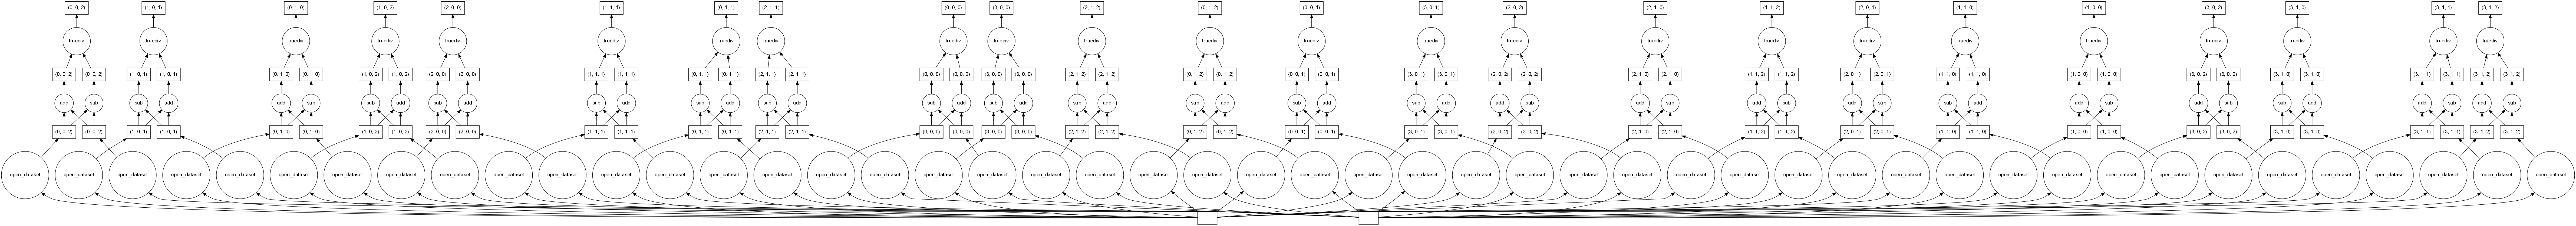

In [7]:
import dask
dask.visualize(ndvi)

## Guide

### 1. Avoid loading data eagerly

Stay as long as possible with Dask-arrays to retain the chunked nature of .

The following properties and operations will load data eagerly 
and should be avoided:

* `b8 = cube.B08.values`: entirely loads data of array `ds.B08` 
  as numpy array into memory and stores it in `b8`.
* `b8 = cube.B08.compute()`: does almost the same as `cube.B08.values`.
* `cube.B08.load()`: this inplace-operation replaces the data of `cube.B08` by the
  result of `cube.B08.compute()`.
* `cube['NDVI'] = xr.DataArray(ndvi)`: the `xarray.DataArray` constructor will 
  eagerly load data of `ndvi`. Then `cube.NDVI.data` is **not a Dask-array, 
  but a Numpy-array** loading entirely into memory. 
  
The latter may be an unintended `xarray 0.19` limitation or even a bug.

In [ ]:
import xarray as xr

# cube['NDVI'] = xr.DataArray(ndvi)    # takes long time to load!
# type(cube.NDVI.data)

### 2. Replace Numpy by Dask counterparts

Given you either know a good chunk sizes `chunks` for your data arrays or you 
need to be compatible with the chunking of an exististing Dask-array or xarray 
instance. For example, instead of `np.zeros(shape)` use the lazy Dask-version:

In [ ]:
mask = dask.array.zeros(cube.B01.shape, chunks=cube.B01.chunks)
mask

For other counterparts use the [Dask-array API reference](https://docs.dask.org/en/stable/array-api.html).

### 3. Avoid writing for-loops

TODO: explain how to avoid for-loops, refer to [numba](https://numba.pydata.org/), refer to fancy indexing and slicing

### 4. Pre-compute reductions before using them further

TODO: Explain why, when, and how `dask.compute()`

### 5. Use Dask and Numba to implement custom array operations 

TODO: explain how to 

* use automatic parallelisation using [ufuncs and map_blocks](`https://xarray.pydata.org/en/stable/user-guide/dask.html#automatic-parallelization-with-apply-ufunc-and-map-blocks)
* use xcube `compute_cube` function

### 6. Test your code for upscaling

TODO: descibe why it is important run code against a configured Dask Scheduler

In [ ]:
import dask.distributed

dask.distributed.Client()

### 7. Run your code using xcube Generator Service

TODO: descibe 

* xcube Generator Service (link) and 
* describe how to provide the _xcube entry point function or class (BYOA)_.

### 8. Other xcube features that allow for efficient computations

TODO: mention

* the handy `xcube.core.maskset.MaskSet` class
* the handy `xcube.core.geo,m.rasterize_features()` function